In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from keras import Model, Sequential
from keras.utils import plot_model
#from keras.applications.mobilenet_v3 import preprocess_input

classifier_activation = 'relu'
weights = 'imagenet'
classes = 1
input_shape = (96, 96, 3)
alpha = 1.0

m1 = MobileNetV3Large(input_shape=input_shape, alpha=alpha, weights=weights, include_top=False)
m2 = MobileNetV3Large(input_shape=input_shape, alpha=alpha, classes=classes, weights=None, classifier_activation=classifier_activation)

model = Sequential()
model.add(m1)

for i in range(-6, 0):
  layer = m2.get_layer(index=i)
  model.add(layer)

model.layers[-1]

m1 = None
m2 = None

17612800/17605208 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 3, 3, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 1, 1, 1280)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1280)        0         
_________________________________________________________________
Logits (Conv2D)              (None, 1, 1, 1)           1281      
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
_________________________________________________________________
Predictions (Activation)     (None, 1)                 0

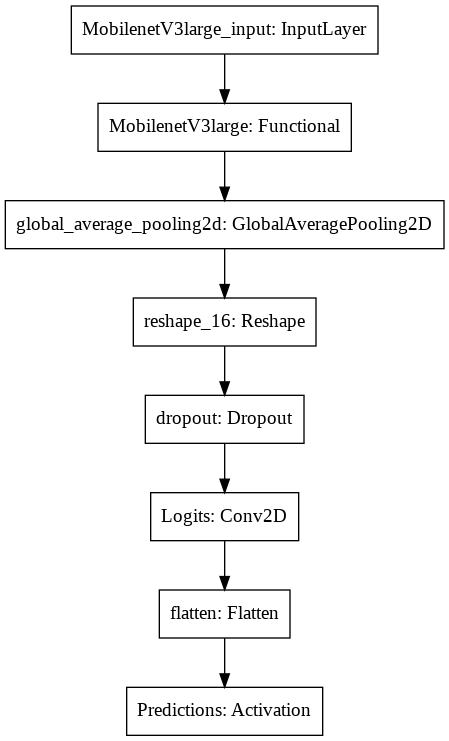

In [ ]:
model.summary()
plot_model(model)

In [ ]:
### COSE UTILI

MODEL_NAME = f"MNV3L_{input_shape[0]}x{input_shape[1]}_c{classes}_a{alpha}_{weights}"
BASE_PATH = '/content/drive/Shareddrives/Progettone\ Importante/Age\ Estimation/Training/'

In [ ]:
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

optimizer = Adam()
loss = MeanSquaredError()
metrics = [ MeanAbsoluteError(name='mae') ]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# DEFINISCI GENERATORI QUA

train_generator = None
eval_generator = None
test_generator = None

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from datetime import datetime
import os
import pickle

batch_size = 24
training_epochs = 100
initial_epoch = 0

min_delta = 0.1 # Quanto deve scendere il mae per esser considerato migliorato
monitor = 'mae' # CONTROLLARE SE QUESTO NOME VA BENE!!!
mode = 'auto' # Controllare che funzioni, ossia il mae deve scendere per essere considerato migliorato
factor = 0.2 # lr = lr * factor
patience_lr = 2 # Cambiare in base alla lunghezza dell'epoca
patience_stop = 5

os.chdir(BASE_PATH)
datetime = datetime.today().strftime('%Y%m%d_%H%M%S')
dirnm = f"{datetime}_{MODEL_NAME}"
os.mkdir(dirnm)
os.chdir(dirnm)

logger = CSVLogger(f'{dirnm}_training.log', append=False)

reduce_lr_plateau= ReduceLROnPlateau(monitor=monitor, 
                                     factor=factor, 
                                     mode=mode, 
                                     verbose=1, 
                                     patience=patience_lr, 
                                     cooldown=1, 
                                     min_delta=min_delta)

early_stopping = EarlyStopping(patience=patience_stop, 
                               verbose=1, 
                               restore_best_weights=True, 
                               monitor=monitor, 
                               mode=mode, 
                               min_delta=min_delta)

model_checkpoint = ModelCheckpoint(dirnm, 
                                   verbose=1, 
                                   save_weights_only=False,
                                   save_best_only=True, 
                                   monitor=monitor, 
                                   mode=mode)

history = model.fit_generator(train_generator, 
                              validation_data=eval_generator, 
                              initial_epoch=initial_epoch,
                              epochs=training_epochs, 
                              callbacks=[model_checkpoint, 
                                         early_stopping, 
                                         logger, 
                                         reduce_lr_plateau])


with open(f"{dir}_training_history", 'wb') as f:
  print("Saving history.")
  pickle.dump(history, f)

model.save(f"{dir}_end")